In [42]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

C:\Users\Pablo\AppData\Local\Temp\ipykernel_30476\822149826.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [43]:
iris = sns.load_dataset('iris')

data = torch.tensor(iris.drop('species', axis=1).values, dtype=torch.float32)
labels = iris['species'].map({'setosa': 0, 'versicolor': 1, 'virginica': 2}).values
labels = torch.tensor(labels, dtype=torch.long) # torch long is used for classification labels

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batchsize = 64
# drop_last=True is used to drop the last batch if it's smaller than the specified batch size, 
# which can help maintain consistent batch sizes during training.
train_dataset = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, drop_last=True) 
test_dataset = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0], shuffle=False) # load all

In [45]:
# L1 regularization can not be easily implemented in PyTorch using built-in layers, but we can add 
# the L1 penalty to the loss function manually during training. For simplicity, we will implement 
# a model without dropout and then add L1 regularization to the loss.

def create_model(learning_rate):
    model = nn.Sequential(
        nn.Linear(4, 64), # first layer takes 4 input features and outputs 64 hidden units
        nn.ReLU(),
        nn.Linear(64, 64), # second layer takes 64 input features and outputs 64 hidden units
        nn.ReLU(),
        nn.Linear(64, 3) # output layer takes 64 input features and outputs 3 classes
    )
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    return model, loss_fn, optimizer

In [46]:
# train the model
def train_model(model, loss_fn, optimizer, train_loader, test_loader, num_epochs=1000):
    train_acc = []
    test_acc = []
    losses = []
    
    for epoch in range(num_epochs):
        batch_losses = []
        batch_accuracies = []
        
        model.train()
        for X_batch, y_batch in train_loader:
            
            # forward pass
            y_pred_logits = model(X_batch)
            loss = loss_fn(y_pred_logits, y_batch)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # record batch loss and accuracy
            batch_losses.append(loss.item())
            batch_acc = (torch.argmax(y_pred_logits, dim=1) == y_batch).float().mean().item()
            batch_accuracies.append(batch_acc)

        train_acc.append(np.mean(batch_accuracies))
        losses.append(np.mean(batch_losses))
        
        # evaluate on test data
        model.eval()        
        X_test, y_test = test_loader.dataset.tensors
        y_pred_test_logits = model(X_test)
        y_pred_test = torch.argmax(y_pred_test_logits, dim=1)
        test_acc_item = (y_pred_test == y_test).float().mean().item()
        test_acc.append(test_acc_item)
    
    return train_acc, test_acc, losses

def smooth(x, k=5):
    # simple moving average to smooth the training loss curve for better visualization
    return np.convolve(x, np.ones(k)/k, mode='valid')

In [47]:
# Access the model's parameters
temp_model, loss_fn, optimizer = create_model(learning_rate=0.01)

# We see 0, 2 and 4 layers, the 1 and 3 are the ReLU activations which do not have parameters
for i in temp_model.named_parameters():
    print(f"Tensor Name: {i[0]}, Shape: {i[1].shape} with a total of {i[1].numel()} parameters")

Tensor Name: 0.weight, Shape: torch.Size([64, 4]) with a total of 256 parameters
Tensor Name: 0.bias, Shape: torch.Size([64]) with a total of 64 parameters
Tensor Name: 2.weight, Shape: torch.Size([64, 64]) with a total of 4096 parameters
Tensor Name: 2.bias, Shape: torch.Size([64]) with a total of 64 parameters
Tensor Name: 4.weight, Shape: torch.Size([3, 64]) with a total of 192 parameters
Tensor Name: 4.bias, Shape: torch.Size([3]) with a total of 3 parameters


In [48]:
def train_model(l1_lambda, model, loss_fn, optimizer, train_loader, test_loader, num_epochs):
    train_acc = []      
    test_acc = []
    losses = []
    
    n_weights = 0
    for param_name, weight in model.named_parameters():
        if 'weight' in param_name: # only consider weight parameters for L1 regularization, not biases
            n_weights += weight.numel()

    for epoch in range(num_epochs):
        batch_losses = []
        batch_accuracies = []
        
        #model.train() we dont need to set train mode for L1 regularization since we are not using dropout or batchnorm, 
        # but we can still do it for consistency
        for X_batch, y_batch in train_loader:
            
            # forward pass
            y_batch_pred_logits = model(X_batch)
            loss = loss_fn(y_batch_pred_logits, y_batch)

            # Add L1 regularization penalty to the loss
            l1_penalty = 0
            for param_name, weight in model.named_parameters():
                if 'weight' in param_name: # only consider weight parameters for L1 regularization, not biases
                    l1_penalty += torch.sum(torch.abs(weight))
            # for L1 we dont divide by 2*n_weights because we are not squaring the weights, 
            # but we can still normalize by the number of weights to keep the scale of the penalty consistent
            l1_penalty = l1_lambda * l1_penalty / n_weights # normalize by number of weights
            loss += l1_penalty

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # record batch loss and accuracy
            batch_losses.append(loss.item())
            batch_acc_item = (torch.argmax(y_batch_pred_logits, dim=1) == y_batch).float().mean().item()
            batch_accuracies.append(batch_acc_item)

        # Train accuracy and loss for the epoch
        train_acc.append(np.mean(batch_accuracies))
        losses.append(np.mean(batch_losses))

        # Test accuracy for the epoch
        #model.eval()
        X_test, y_test = next(iter(test_loader)) # get all test data
        y_test_pred_logits = model(X_test)
        y_test_pred = torch.argmax(y_test_pred_logits, dim=1)
        test_acc_item = (y_test_pred == y_test).float().mean().item()
        test_acc.append(test_acc_item)

    return train_acc, test_acc, losses

In [49]:
num_epochs = 1000
learning_rate = 0.005
l1_lambda = np.linspace(0, 0.005, 10) 

accuracies_train = np.zeros((num_epochs, len(l1_lambda)))
accuracies_test = np.zeros((num_epochs, len(l1_lambda)))

for i, l1 in enumerate(l1_lambda):
    model, loss_fn, optimizer = create_model(learning_rate)
    train_acc, test_acc, losses = train_model(l1, model, loss_fn, optimizer, train_dataset, test_dataset, num_epochs)
    accuracies_train[:, i] = train_acc
    accuracies_test[:, i] = test_acc

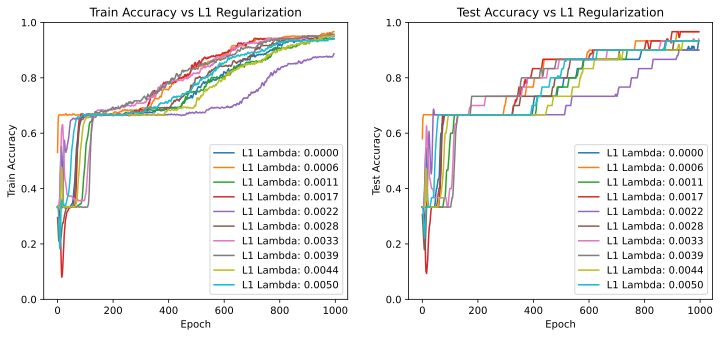

In [50]:
def smooth(x, k=5):
    # simple moving average to smooth the training loss curve for better visualization
    return np.convolve(x, np.ones(k)/k, mode='valid')

fig = plt.subplots(1, 2, figsize=(12, 5))
for i, l1 in enumerate(l1_lambda):
    plt.subplot(1, 2, 1)
    plt.plot(smooth(accuracies_train[:, i]), label=f'L1 Lambda: {l1:.4f}')
    plt.xlabel('Epoch')
    plt.ylabel("Train Accuracy")
    plt.ylim(0, 1)
    plt.legend()
    plt.title("Train Accuracy vs L1 Regularization")

    plt.subplot(1, 2, 2)
    plt.plot(smooth(accuracies_test[:, i]), label=f'L1 Lambda: {l1:.4f}')
    plt.xlabel('Epoch')
    plt.ylabel("Test Accuracy")
    plt.ylim(0, 1)
    plt.legend()
    plt.title("Test Accuracy vs L1 Regularization")

(0.6, 1.01)

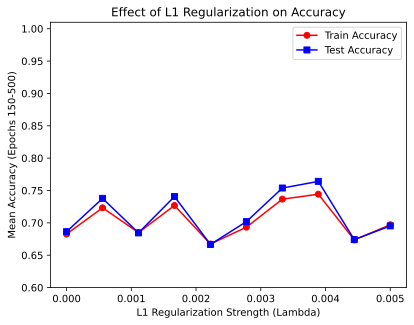

In [51]:
epoch_range = [150, 500] # to check which value of l1 allows the model to learn faster

mean_test_acc = np.mean(accuracies_test[epoch_range[0]:epoch_range[1], :], axis=0)
mean_train_acc = np.mean(accuracies_train[epoch_range[0]:epoch_range[1], :], axis=0)

plt.plot(l1_lambda, mean_train_acc, "ro-", label='Train Accuracy')
plt.plot(l1_lambda, mean_test_acc, "bs-", label='Test Accuracy')
plt.xlabel('L1 Regularization Strength (Lambda)')
plt.ylabel('Mean Accuracy (Epochs 150-500)')
plt.title('Effect of L1 Regularization on Accuracy')
plt.legend()
plt.ylim(0.6, 1.01)